In [1]:
#Import dependency libraries
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [2]:
#Load the Dataset
iris = load_iris()
type(iris)

sklearn.utils.Bunch

In [3]:
# Names of features/columns in iris dataset
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [4]:
#shape of dataset
iris.data.shape

(150, 4)

In [5]:
#Function to formatting dataset
def data_set(data,target):
  data = data.tolist()
  for i in range(len(data)):
    data[i].extend([target[i]])
  return data

In [6]:
data = iris.data
target = iris.target

In [7]:
#formatting dataset
iris_dataset = data_set(data,target)
len(iris_dataset)

150

In [8]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
        dataset_split = list()
        dataset_copy = list(dataset)
        fold_size = int(len(dataset) / n_folds)
        for i in range(n_folds):
                fold = list()
                while len(fold) < fold_size:
                        index = randrange(len(dataset_copy))
                        fold.append(dataset_copy.pop(index))
                dataset_split.append(fold)
        return dataset_split

In [9]:
# Initialize a vanilla neural network based on required neurons in layer
def initialize_network(n_inputs, n_hidden, n_outputs):
        network = list()
        hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)], 'prev':[0 for i in range(n_inputs+1)]} for i in range(n_hidden)]        
        network.append(hidden_layer)
        output_layer = [{'weights':[random() for i in range(n_hidden + 1)],'prev':[0 for i in range(n_hidden+1)]} for i in range(n_outputs)]
        network.append(output_layer)
        #print(network)
        return network

In [11]:
#method to calculate net value for each neuron in a layer
def activate(weights, inputs):
        #Get the bias value 
        activation = weights[-1]
        #calculate neuron net value
        for i in range(len(weights)-1):
                activation += weights[i] * inputs[i]
        return activation

In [12]:
# Transfer neuron activation(using sigmoid activation function)
def transfer(activation):
        return 1.0 / (1.0 + exp(-activation))

In [13]:
# Forward propagate input to a network output
def forward_propagate(network, row):
        inputs = row
        #loop through each layer in network
        for layer in network:
                new_inputs = []
                #loop through each neuron in layer
                for neuron in layer:
                        #calculate linear transformation for a neuron by taking input(each row)
                        activation = activate(neuron['weights'], inputs)
                        
                        #passing linear transformation output to Activationfunction
                        neuron['output'] = transfer(activation)
                        
                        #add the each neuron output into new_inputs to pass it to next layer of neurons
                        new_inputs.append(neuron['output'])
                inputs = new_inputs
                
        #return the output for each row in dataset        
        return inputs

In [14]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
        epochs=[]
        accuracy=[]
        for epoch in range(n_epoch):
                results=[]
                for row in train:
                        outputs = forward_propagate(network, row)
                        #Converting probability values into 0 or 1
                        pred = [int(i > .5) for i in outputs]
                        
                        #get the expected results                        
                        expected = [0 for i in range(n_outputs)]
                        expected[row[-1]] = 1
                        
                        row_res = row_acc(expected,pred)
                        results.extend(row_res)
                            
                        #print("expected row{}\n".format(expected))
                        backward_propagate_error(network, expected)
                        update_weights(network, row, l_rate)
                
                accra=sum(results)/len(results)
                accuracy.append(accra)
                epochs.append(epoch)
        return accuracy,epochs

In [15]:
#evaluation for each row output
def row_acc(expected,pred):
    accu=[]
    if pred==expected:
        accu.append(1)
    else : accu.append(0)
    return accu

In [16]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
        n_inputs = len(train[0]) - 1
        n_outputs = len(set([row[-1] for row in train]))
        network = initialize_network(n_inputs, n_hidden, n_outputs)
        accuracy,epoch = train_network(network, train, l_rate, n_epoch, n_outputs)
        #print("network {}\n".format(network))
        predictions = list()
        for row in test:
                prediction = predict(network, row)
                predictions.append(prediction)
        return(predictions,accuracy,epoch)

In [17]:
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
        for i in reversed(range(len(network))):
                layer = network[i]
                errors = list()
                if i != len(network)-1:
                        for j in range(len(layer)):
                                error = 0.0
                                for neuron in network[i + 1]:
                                        error += (neuron['weights'][j] * neuron['delta'])
                                errors.append(error)
                else:
                        for j in range(len(layer)):
                                neuron = layer[j]
                                errors.append(expected[j] - neuron['output'])
                for j in range(len(layer)):
                        neuron = layer[j]
                        neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [18]:
# Calculate the derivative of an neuron output
def transfer_derivative(output):
        return output * (1.0 - output)

In [19]:
# Make a prediction with a network
def predict(network, row):
        outputs = forward_propagate(network, row)
        return outputs.index(max(outputs))

In [20]:
# Update network weights with error
def update_weights(network, row, l_rate):
        for i in range(len(network)):
                inputs = row[:-1]                
                if i != 0:
                        inputs = [neuron['output'] for neuron in network[i - 1]]
                for neuron in network[i]:
                        for j in range(len(inputs)):
                                temp = l_rate * neuron['delta'] * inputs[j] + mu * neuron['prev'][j]
                                
                                neuron['weights'][j] += temp
                                #print("neuron weight{} \n".format(neuron['weights'][j]))
                                neuron['prev'][j] = temp
                        temp = l_rate * neuron['delta'] + mu * neuron['prev'][-1]
                        neuron['weights'][-1] += temp
                        neuron['prev'][-1] = temp

In [21]:
# Evaluate an algorithm using a cross validation split
def run_algorithm(dataset, algorithm, n_folds, *args):
        
        folds = cross_validation_split(dataset, n_folds)
        #for fold in folds:
                #print("Fold {} \n \n".format(fold))
        scores = list()
        Nfold = 1
        for fold in folds:
                #print("Test Fold {} \n \n".format(fold))
                train_set = list(folds)
                train_set.remove(fold)
                train_set = sum(train_set, [])
                test_set = list()
                for row in fold:
                        row_copy = list(row)
                        test_set.append(row_copy)
                        row_copy[-1] = None
                predicted,accuarcy,epoch = algorithm(train_set, test_set, *args)
          
                #Get the actual target values from test dataset
                actual = [row[-1] for row in fold]
                #Evaluation for test dataset
                accuracy = accuracy_met(actual, predicted)
                cm = confusion_matrix(actual, predicted)
                print('For Fold {} results:'.format(Nfold))
                print('Confusion Matrix:')
                print('\n'.join([''.join(['{:4}'.format(item) for item in row]) for row in cm]))
                confusionmatrix = np.matrix(cm)
                FP = cm.sum(axis=0) - np.diag(cm)
                FN = cm.sum(axis=1) - np.diag(cm)
                TP = np.diag(cm)
                TN = cm.sum() - (FP + FN + TP)
                #print('False Positives\n {}'.format(FP))
                #print('False Negetives\n {}'.format(FN))
                #print('True Positives\n {}'.format(TP))
                #print('True Negetives\n {}'.format(TN))
                TPR = TP/(TP+FN)
                print('Sensitivity \n {}'.format(TPR))
                TNR = TN/(TN+FP)
                print('Specificity \n {}'.format(TNR))
                Precision = TP/(TP+FP)
                print('Precision \n {}'.format(Precision))
                Recall = TP/(TP+FN)
                print('Recall \n {}'.format(Recall))
                Acc = (TP+TN)/(TP+TN+FP+FN)
                #print('Áccuracy \n{}'.format(Acc))
                Fscore = 2*(Precision*Recall)/(Precision+Recall)
                print('FScore \n{}'.format(Fscore))
                scores.append(accuracy)
                Nfold+=1
                print('\n\n')
        #plt.plot(epoch, accuarcy, label = "line 1")
        #print(epoch)
        #print(accuarcy)
        return (scores,epoch,accuarcy)

In [22]:
# Calculate accuracy percentage
def accuracy_met(actual, predicted):
        correct = 0
        for i in range(len(actual)):
                if actual[i] == predicted[i]:
                        correct += 1
        return correct / float(len(actual)) * 100.0

In [23]:
# Test Backprop on Seeds dataset
seed(1)

# evaluate algorithm
n_folds = 5
l_rate = 0.1
mu=0.001
n_epoch = 100
n_hidden = 5

In [24]:
scores,epoch,accuarcy = run_algorithm(iris_dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)

For Fold 1 results:
Confusion Matrix:
  11   0   0
   1   6   1
   0   0  11
Sensitivity 
 [1.   0.75 1.  ]
Specificity 
 [0.94736842 1.         0.94736842]
Precision 
 [0.91666667 1.         0.91666667]
Recall 
 [1.   0.75 1.  ]
FScore 
[0.95652174 0.85714286 0.95652174]



For Fold 2 results:
Confusion Matrix:
  10   0   0
   0   9   2
   0   0   9
Sensitivity 
 [1.         0.81818182 1.        ]
Specificity 
 [1.        1.        0.9047619]
Precision 
 [1.         1.         0.81818182]
Recall 
 [1.         0.81818182 1.        ]
FScore 
[1.  0.9 0.9]



For Fold 3 results:
Confusion Matrix:
   6   0   0
   0  10   0
   0  14   0
Sensitivity 
 [1. 1. 0.]
Specificity 
 [1.  0.3 1. ]
Precision 
 [1.         0.41666667        nan]
Recall 
 [1. 1. 0.]
FScore 
[1.         0.58823529        nan]





<ipython-input-21-57bffad2e5ea>:42: RuntimeWarning: invalid value encountered in true_divide
  Precision = TP/(TP+FP)


For Fold 4 results:
Confusion Matrix:
  10   0   0
   0   9   1
   0   0  10
Sensitivity 
 [1.  0.9 1. ]
Specificity 
 [1.   1.   0.95]
Precision 
 [1.         1.         0.90909091]
Recall 
 [1.  0.9 1. ]
FScore 
[1.         0.94736842 0.95238095]



For Fold 5 results:
Confusion Matrix:
  13   0   0
   0   6   5
   0   0   6
Sensitivity 
 [1.         0.54545455 1.        ]
Specificity 
 [1.         1.         0.79166667]
Precision 
 [1.         1.         0.54545455]
Recall 
 [1.         0.54545455 1.        ]
FScore 
[1.         0.70588235 0.70588235]





Text(0, 0.5, 'train_accuarcy')

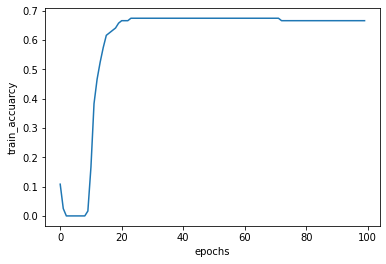

In [27]:
#Plot for epochs vs train accuracy
plt.plot(epoch, accuarcy)
plt.xlabel('epochs')
plt.ylabel('train_accuarcy')

In [26]:
#Accuracy score for different test folds
scores

[93.33333333333333,
 93.33333333333333,
 53.333333333333336,
 96.66666666666667,
 83.33333333333334]